In [2]:
%load_ext autoreload

In [11]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
import colorcet as cc

import torch
import torch.distributions as dist

import umap.umap_ as umap

from hmmlearn import hmm
from model import HMMPoisson
from utils import *

# Import data

In [4]:
df = pd.read_csv("df.csv")
X_pd = df.drop(columns= ["headAngel", "sin_angel", "cos_angel"])
y = df.headAngel

# Vizualization


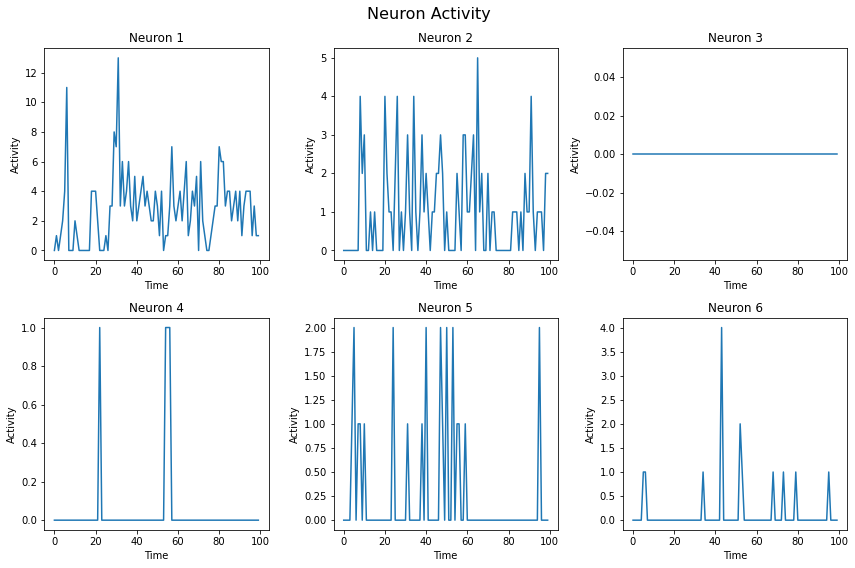

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Neuron Activity", fontsize=16)

t = 100 

for i in range(6):
    row, col = divmod(i,3)
    ax = axes[row, col]
    
    ax.plot(range(t), df[f"cell_{i}"][0:t])
    ax.set_title(f"Neuron {i + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Activity")

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

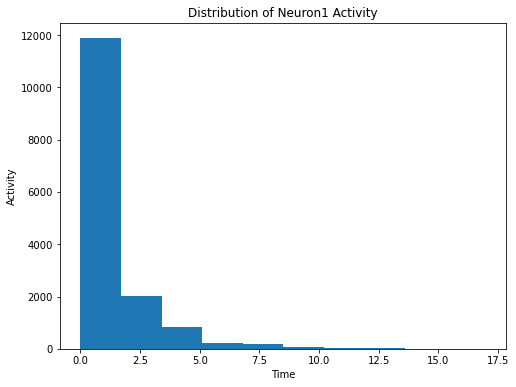

In [6]:
# Create a bar plot for the distribution of Neuron1's activity
plt.figure(figsize=(8, 6))

plt.hist(df["cell_0"])

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Activity')
plt.title('Distribution of Neuron1 Activity')

# Show the plot
plt.show()


# Remove inactive neurons

In [7]:
X_pd = X_pd.loc[:,X_pd.sum(axis=0) > 100]
X_pd.shape

(15243, 59)

# UMAP

In [17]:
df_pure = df[~np.isnan(df["headAngel"])]

X_pure = df_pure.drop(columns= ["headAngel", "sin_angel", "cos_angel"])
y_pure = df_pure.headAngel

X_pure = X_pure.loc[:,X_pure.sum(axis=0) > 100]

In [18]:
X_scaled = StandardScaler().fit_transform(X_pure)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

In [19]:
def map_list_to_segments(values, num_segments=10):
    segment_indices = []

    for value in values:
        if value < 0:
            value = 0
        elif value >= 2 * np.pi:
            value = 2 * np.pi - 1e-6  # To ensure that 2π gets mapped to the last segment.
        
        segment_width = (2 * np.pi) / num_segments
        segment_index = int(value / segment_width)
        segment_indices.append(segment_index)

    return segment_indices

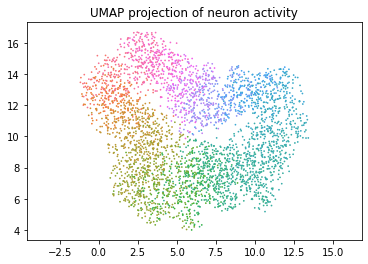

In [20]:
segment_hd = map_list_to_segments(y_pure, len(y_pure))
custom_palette = sns.color_palette("husl", len(segment_hd))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[custom_palette[x] for x in segment_hd], s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

# Modeling

## Own model

In [15]:
n_states = 12
X = torch.tensor(X_pd.values)
n_retraining = 1
m_dimensions = X.shape[1]

model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = HMMPoisson(n_states = n_states, m_dimensions=m_dimensions, verbose=True, max_itterations = 8, tolerance = 500, use_cuda = False)
    model.fit(X)

    model_list.append(model)
    score_list.append(model.forward(X).item())
    print(f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

1 -2425239.5000  +inf
2 -1017199.7500  +1408039.75
3 -926167.6250  +91032.125
4 -907145.2500  +19022.375
5 -899805.9375  +7339.3125
6 -896567.8750  +3238.0625
7 -894782.3750  +1785.5


## Sklearn model

In [8]:
n_states = 15
X = X_pd
n_retraining = 5

model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = hmm.PoissonHMM(n_components = n_states, verbose=True, random_state = idx, n_iter=15, tol = 500)
    try:
        model.fit(X)
    except:
        score_list.append(-np.inf)
        continue
    
    model_list.append(model)
    score_list.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}\t\t'
              f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

         1 -4219375.89381984             +nan
         2 -1024856.23541001 +3194519.65840983
         3 -919951.14731368 +104905.08809634
         4 -896882.96616590  +23068.18114777
         5 -885564.56919703  +11318.39696887
         6 -882460.81548964   +3103.75370740
         7 -881354.12025009   +1106.69523954
         8 -880243.89445011   +1110.22579998
         9 -878863.42059582   +1380.47385429
        10 -878314.97881773    +548.44177809
        11 -878055.70944512    +259.26937261


Converged: True		Score: -877890.8531306189


         1 -3177158.69908032             +nan
         2 -1098049.77283293 +2079108.92624739
         3 -984527.32129344 +113522.45153949
         4 -936659.05738201  +47868.26391143
         5 -922675.24346177  +13983.81392024
         6 -917330.31934326   +5344.92411851
         7 -913763.42425664   +3566.89508661
         8 -910667.64498209   +3095.77927455
         9 -908823.89935963   +1843.74562246
        10 -907837.68426661    +986.21509302
        11 -906491.07879009   +1346.60547652
        12 -905592.56859277    +898.51019732
        13 -905068.69465509    +523.87393768
        14 -904670.01400964    +398.68064545


Converged: True		Score: -904275.1172516461


         1 -3636726.00499548             +nan
         2 -1006757.55297734 +2629968.45201814
         3 -928653.07757862  +78104.47539872
         4 -904471.94363457  +24181.13394405
         5 -893633.55586624  +10838.38776833
         6 -889933.24229556   +3700.31357068
         7 -887905.83027458   +2027.41202098
         8 -886520.44016843   +1385.39010614
         9 -885649.99737147    +870.44279697
        10 -884908.71043745    +741.28693401
        11 -884325.51080055    +583.19963690
        12 -883896.13533917    +429.37546139


Converged: True		Score: -883545.4782641681


         1 -4204386.81830444             +nan
         2 -1028298.62673296 +3176088.19157149
         3 -913392.03639310 +114906.59033986
         4 -892650.41568151  +20741.62071159
         5 -887928.30378748   +4722.11189402
         6 -885173.36193155   +2754.94185594
         7 -883112.01577628   +2061.34615527
         8 -881881.16903758   +1230.84673870
         9 -880933.62294326    +947.54609432
        10 -879984.25659432    +949.36634893
        11 -879260.71098199    +723.54561233
        12 -878748.52364111    +512.18734088
        13 -878470.89557216    +277.62806895


Converged: True		Score: -878320.3715633343


         1 -4201450.96611851             +nan
         2 -1096373.38381466 +3105077.58230384
         3 -932404.24451165 +163969.13930301
         4 -901159.80725929  +31244.43725236
         5 -894656.64654454   +6503.16071476
         6 -891866.54554425   +2790.10100029
         7 -889742.20492387   +2124.34062038
         8 -887894.24376480   +1847.96115907
         9 -886663.52647727   +1230.71728753
        10 -885821.66409310    +841.86238417
        11 -885264.14712635    +557.51696674
        12 -884757.88036169    +506.26676467
        13 -884283.21407785    +474.66628384


Converged: True		Score: -883795.0768871707
--- 116.9350094795227 seconds ---


## Get best prediction

In [9]:
model = model_list[np.argmax(score_list)]
states_head = model.predict(X)

# Visualizing the Result

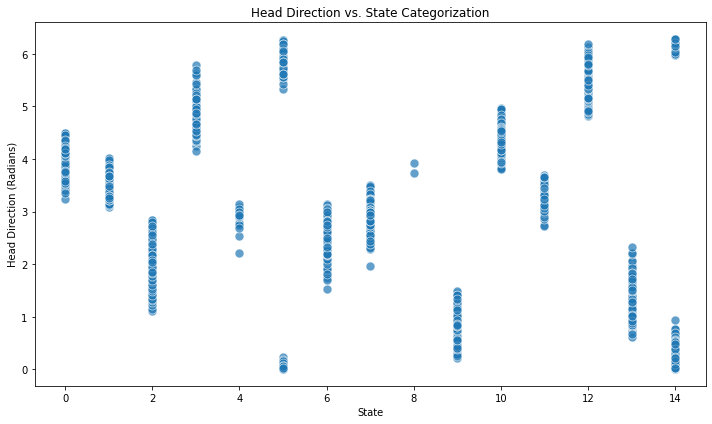

In [10]:
scatterplot_with_color(y, states_head)

In [13]:
palette = sns.color_palette(cc.glasbey, n_colors=len(set(states_head)))

15

In [34]:
%autoreload
from utils import *

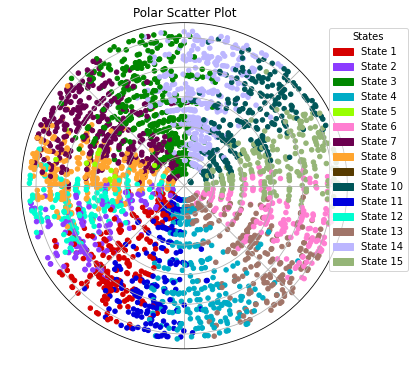

In [35]:
plot_polar_scatter(y, states_head)